In [82]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [83]:
# Import netket library
import netket as nk

# Import Json, this will be needed to load log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from dm_ham import DMOp

In [84]:

L = 4
g = nk.graph.Triangular(extent=[L, L], pbc=True)
hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes, total_sz=0)
# ha = DMOp(hilbert=hi, graph=g, J=1, DM=0)
ha = nk.operator.Heisenberg(hilbert=hi, graph=g, J=1)

exact_gs_energy = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
print(exact_gs_energy)


[-34.22205967]


In [78]:
import flax.linen as nn
import jax.numpy as jnp
import jax

class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        # sometimes we call this function with a 1D input, sometimes with a 2D.
        # We promote all inputs to 2D to make the following code simpler.
        x = jnp.atleast_2d(x)
        # We vmap along the 0-th axis of the input
        # This will automatically convert a function working on vectors to one working
        # on matrices.
        return jax.vmap(self.evaluate_single, in_axes=(0))(x)
        
    def evaluate_single(self, x):
        # We create the parameter v, which is a vector of length N_sites 
        v_bias = self.param(
            "visible_bias", nn.initializers.normal(), (x.shape[-1],), complex
        )
    
        # The Jastrow matrix is a N_sites x N_sites complex-valued matrix
        J = self.param(
            "kernel", nn.initializers.normal(), (x.shape[-1],x.shape[-1]), complex
        )
        
        # In python @ symbolises matrix multiplication
        return x.T@J@x + jnp.dot(x, v_bias)
ma = Jastrow()

# Build the sampler
# sa = nk.sampler.MetropolisLocal(hilbert=hi)
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.1)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

sigmax = np.sum([nk.operator.spin.sigmax(hi, i) for i in range(g.n_nodes)])/g.n_nodes
sigmay = np.sum([nk.operator.spin.sigmay(hi, i) for i in range(g.n_nodes)])/g.n_nodes
sigmaz = np.sum([nk.operator.spin.sigmaz(hi, i) for i in range(g.n_nodes)])/g.n_nodes
start = time.time()
gs.run(300, out='Jastrow', obs= {'sigmax': sigmax, 'sigmay': sigmay, 'sigmaz': sigmaz})
end = time.time()

print('### Jastrow calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',end-start,'seconds')

100%|██████████| 300/300 [00:11<00:00, 25.10it/s, Energy=-11.9997896-0.0002995j ± 0.0000033 [σ²=0.0000000, R̂=1.4086]]

### Jastrow calculation
Has 272 parameters
The Jastrow calculation took 14.461606979370117 seconds


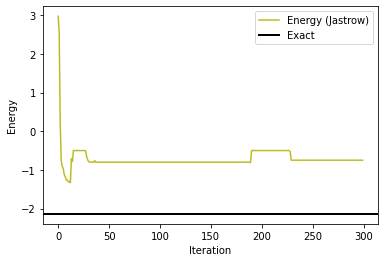

In [79]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))
   
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = np.array(data_Jastrow["Energy"]["Mean"]["real"])
sigmaxs = data_Jastrow["sigmax"]["Mean"]["real"]
sigmays = data_Jastrow["sigmay"]["Mean"]["real"]
sigmazs = data_Jastrow["sigmaz"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
# plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy[0], xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

In [73]:
data_Jastrow['Energy']['Mean']['imag']

[0.06510808570064296,
 0.19539272404832575,
 0.8366158071320496,
 0.21768322597314613,
 -0.21319606632998384,
 0.054900982821067625,
 -0.2671886934070291,
 0.2224810174410663,
 0.2366911732335388,
 0.010770261792044608,
 0.009343246939732671,
 -0.2267505247248194,
 9.100569336533465e-06,
 9.100569877164629e-06,
 9.100570417796311e-06,
 9.100570958428476e-06,
 9.100571499061077e-06,
 9.100572039694218e-06,
 9.10057258032778e-06,
 9.100573120961799e-06,
 9.100573661596081e-06,
 9.10057420223093e-06,
 9.10057474286622e-06,
 9.100575283502113e-06,
 9.100575824138775e-06,
 9.100576364775618e-06,
 9.100576905412679e-06,
 9.100577446050372e-06,
 9.100577986688583e-06,
 9.100578527327116e-06,
 9.100579067966245e-06,
 9.100579608605876e-06,
 9.100580149245892e-06,
 9.100580689886364e-06,
 9.10058123052733e-06,
 9.10058177116885e-06,
 9.100582311810719e-06,
 9.100582852453155e-06,
 9.100583393096006e-06,
 9.10058393373915e-06,
 9.100584474383052e-06,
 9.10058501502715e-06,
 9.100585555672004e-06

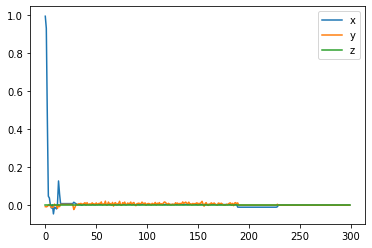

In [80]:
plt.plot(iters_Jastrow, sigmaxs, label="x")
plt.plot(iters_Jastrow, sigmays, label="y")
plt.plot(iters_Jastrow, sigmazs, label="z")
plt.legend()

In [75]:
ma = nk.models.RBM(alpha=1)
# Build the sampler
sa = nk.sampler.MetropolisLocal(hilbert=hi)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.1)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

# sigmax = np.sum([nk.operator.spin.sigmax(hi, i) for i in range(g.n_nodes)])/g.n_nodes
# sigmay = np.sum([nk.operator.spin.sigmay(hi, i) for i in range(g.n_nodes)])/g.n_nodes
# sigmaz = np.sum([nk.operator.spin.sigmaz(hi, i) for i in range(g.n_nodes)])/g.n_nodes
start = time.time()
gs.run(300, out='RBM', obs= {'sigmax': sigmax, 'sigmay': sigmay, 'sigmaz': sigmaz})
end = time.time()

print('### RBM calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The RBM calculation took',end-start,'seconds')

100%|██████████| 300/300 [00:10<00:00, 28.24it/s, Energy=-11.99891 ± 0.00031 [σ²=0.00010, R̂=1.0391]]     

### RBM calculation
Has 288 parameters
The RBM calculation took 10.938597679138184 seconds


In [76]:
# import the data from log file
data_RBM=json.load(open("RBM.log"))
   
iters_RBM = data_RBM["Energy"]["iters"]
energy_RBM = np.array(data_RBM["Energy"]["Mean"]["real"])
# sigmaxs = data_Jastrow["sigmax"]["Mean"]["real"]
# sigmays = data_Jastrow["sigmay"]["Mean"]["real"]
# sigmazs = data_Jastrow["sigmaz"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_RBM/L/L, color='C8', label='Energy (RBM)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
# plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy[0]/L/L, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

TypeError: list indices must be integers or slices, not str

In [62]:
data_Jastrow['Energy']['Mean']['imag']

[0.01020081993941237,
 -0.3972624491295255,
 -0.16101704026379293,
 -0.31357877103380055,
 0.683386520074106,
 0.23146155867417068,
 -0.08468972410807173,
 -0.08397727195652646,
 -0.08403982418741367,
 0.09881668571206333,
 -0.06079217923085773,
 0.026030900416775797,
 0.665839117635973,
 -0.22669635110588207,
 -0.350741617359778,
 0.032334848928848,
 0.007950083729241617,
 0.22406616373077734,
 0.033343418026807826,
 0.09964777254163398,
 -0.2198442659891074,
 -0.09836024284547963,
 -0.11347036733607238,
 0.01621358671104694,
 0.07161395001417134,
 -0.07640786585282096,
 0.07933999236982991,
 0.07451223426607524,
 0.12435261322070823,
 -0.16691663720693906,
 0.2810196183151348,
 0.2130201145305542,
 -0.02946388899358759,
 0.025275596176254727,
 0.06257039130678495,
 -0.007578900551852298,
 -0.0007440393087378383,
 0.03142215394813897,
 -0.10992082974373134,
 -0.11920904652023405,
 -0.0007239695021861619,
 0.011544046051664652,
 0.09152761455732242,
 0.06327624246283135,
 0.37535036443